# Sheet 2
by Michaela and Elias

In [21]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import detrend
import scipy.io
import math 
# Import data
data = scipy.io.loadmat("ex2file1.mat")

In [22]:
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'DLPFC1', 'DLPFC2', 'Parietal1', 'Parietal2'])


## Task 1. Univariate AR models

### 1.
**Write down the formula for an AR(4) model and explain how it can be rewritten as a VAR(1) model. Using this, how would you determine an estimate for the parameters $\{a_i\}_{0:4}$? Write down as a formula and compute numerically.**

In [23]:
dlpfc1 = data['DLPFC1']
dlpfc1 = dlpfc1.flatten()

An $AR(4)$ model is of the form
$$x_t = a_0 + \sum_{i = 1}^{4} a_{i} x_{t-i} + \epsilon_t, \quad \epsilon_t \sim W(0,\sigma^2)$$
for $t = 1,...,T$. $x_t$ is stationary, and $W(0,1)$ denotes a white noise distribution with mean $0$ and variance $\sigma^2$.

The time series can be writen as the following VAR(1) process.
$$y_t = a + A y_{t-1} + \epsilon_t'$$
Where  $y_t = (x_t, x_{t-1}, x_{t-2}, x_{t-3})^T$, $a = (a_0,0,0,0)^T$, $A = \begin{pmatrix} a_1 & a_2 & a_3 & a_4 \\ 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0\\ 0 & 0 & 1 & 0\end{pmatrix}$, $\epsilon_t' = (\epsilon_t, 0,0,0)^T$ 

That the two models are equivalent means that the results we show for one of them can be used for the other. We now use a given time series $y = (x_5,...,x_T)$ and a design matrix $X_p$ to solve the regression problem $y = X_pA$. 
Here, $X_p$ is the design matrix of dimension $(T-4)$ x $5$ where the first column is ones, the second column $x_4, ..., x_T$, the third $x_3,...,x_{T-1}$ and so on. $y$ is the vector of observations, where we discard the first four observations (as we do not have enough preceding observations). We solve the regression problem by minimizing the MSE
$$\text{MSE}(a) = \| y - X_p a \|^2$$
Taking the derivative and setting it to zero yields
$$X_p^T y = X_p^T X_p \hat{a}$$
the solution for the MSE estimates $\hat{a}$ of $\{a_i\}_{0:4}$ for the AR(4) model (and therefore also the VAR(1) model) are then given by:
$$\hat{a} = (X_p^TX_p)^{-1}X^T_p x_T$$

We calculate the estimates

In [24]:
Xp = np.column_stack([
    np.ones((len(dlpfc1)-4)),  
    dlpfc1[3:-1],
    dlpfc1[2:-2],
    dlpfc1[1:-3],
    dlpfc1[0:-4]
])

a_hat = np.linalg.inv(Xp.T @ Xp) @ (Xp.T @ dlpfc1[4:])
print(np.round(a_hat, 3))

[-0.     1.249 -0.483  0.243 -0.17 ]


### 2.
**Compute the log-likelihood of an AR(4) model. Please write the derivation down explicitly.**

We want to compute the log-likelihood:

$$
\log L(a; x) = \log p(x | a)
$$

Since our model is dependent on the previous 4 timesteps the conditional density of data simplifies to

$$
p(x_5, \dots, x_T | x_1, \dots, x_4; a) = \prod_{t=5}^T p(x_t | x_{t-1}, x_{t-2}, x_{t-3}, x_{t-4};a)
$$

Assuming normality of the residuals the log likelihood of the model then reads

$$
\log L(a; x_5, \dots, x_T | x_1, \dots, x_4)
= \sum_{t=5}^T \log \left[ \frac{1}{\sqrt{2\pi \sigma^2}} \exp\left( -\frac{(x_t - \sum_{j=1}^4 a_j x_{t-j})^2}{2\sigma^2} \right) \right]
$$

Which by rules of the logarithm becomes
$$\log L(a; x_5, \dots, x_T | x_1, \dots, x_4) = \sum_{i=1}^T - \frac{1}{2}\log (2\pi\sigma^2)  - \frac{1}{2}\frac{(x_t - \mu_t)^2}{\sigma^2}$$
Where $\mu_t = \sum_{i = 1}^{4} a_{i} x_{t-i}$. 
In order to compute the log likelihood, we will need estimates of $\mu_t$ and an estimate of $\sigma^2$. We can obtain estimates of $\mu_t$ by using our estimates $a_1, a_2, a_3, a_4$. We do this below

In [25]:
hat_mu_t = [a_hat[0] + np.sum(np.flip(a_hat[1:5]) * dlpfc1[t:(t + 4)]) for t in range(len(dlpfc1)-4)]

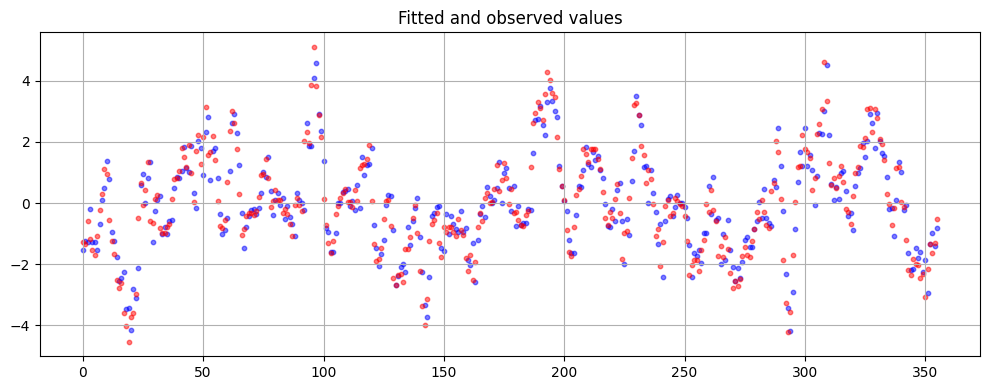

In [26]:
plt.figure(figsize=(10, 4))
plt.scatter(range(0, len(hat_mu_t)), hat_mu_t, color = "blue", s = 10, alpha = 0.5)
plt.scatter(range(0, len(hat_mu_t)), dlpfc1[4:], color = "red", s = 10, alpha=0.5)
plt.title('Fitted and observed values')
plt.grid(True)
plt.tight_layout()
plt.show()

We use the following estimate of $\sigma^2$
$$\hat{\sigma}^2=\frac{1}{T-p} (x_T - \hat{\mu}_t)^T(x_T - \hat{\mu}_t)$$

In [27]:
hat_sigma2 = 1/(len(dlpfc1) - 4) * (dlpfc1[4:] - hat_mu_t) @ (dlpfc1[4:] - hat_mu_t)

Now we can compute the log likelihood estimate

In [28]:
sum(-0.5 * math.log(2 * math.pi * hat_sigma2) - 0.5 * (dlpfc1[4:] - hat_mu_t)*(dlpfc1[4:] - hat_mu_t)/hat_sigma2)

np.float64(-365.7731931660897)

### 3. 
**Plot the residuals of the model in a histogram. What do they look like? What do you expect?**

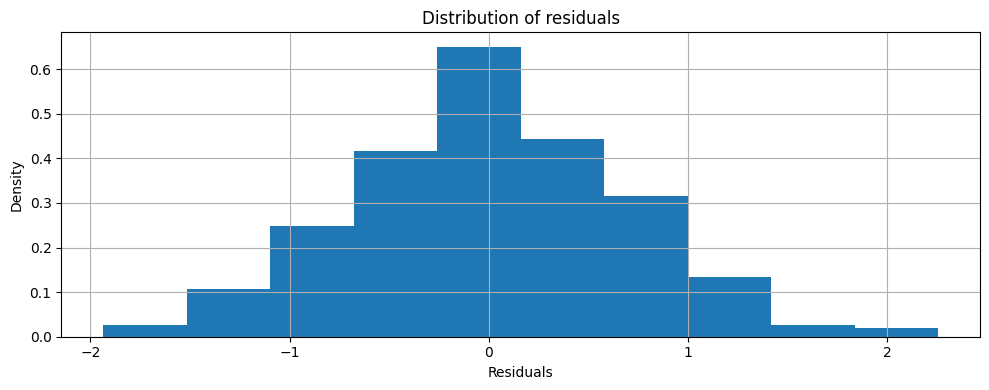

In [29]:
ress = dlpfc1[4:] - hat_mu_t
index = range(len(dlpfc1)-4)

plt.figure(figsize=(10, 4))
plt.hist(ress, density = True)
plt.title('Distribution of residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.grid(True)
plt.tight_layout()
plt.show()

They look fairly normally distributed, with mean $0$. The mean $0$ is achieved by construction of the model, while the normality assumption is not. It is useful to observe that the residuals indeed satisfy the normality assumption, as this can be used for inference. 

### 4. 
**Compute the log-likelihood of an AR(n) model, with n ranging from 1...5. How does the likelihood change when you increase the order of the model?**

We define the design matrices of the different models

In [30]:
Xp_1 = np.column_stack([
    np.ones((len(dlpfc1)-1)),  
    dlpfc1[0:-1]])
Xp_2 = np.column_stack([
    np.ones((len(dlpfc1)-2)),  
    dlpfc1[1:-1],
    dlpfc1[0:-2]])
Xp_3 = np.column_stack([
    np.ones((len(dlpfc1)-3)), 
    dlpfc1[2:-1],
    dlpfc1[1:-2],
    dlpfc1[0:-3]])
Xp_5 = np.column_stack([
    np.ones((len(dlpfc1)-5)),  
    dlpfc1[4:-1],
    dlpfc1[3:-2],
    dlpfc1[2:-3],
    dlpfc1[1:-4],
    dlpfc1[0:-5]])

We define a function for the calculation of the log likelihood as a function of the design matrices and the order of the process. 

In [31]:
def loglik(des_mat, p):
    est = np.linalg.inv(des_mat.T @ des_mat) @ (des_mat.T @ dlpfc1[p:])
    mu_hat = [est[0] + np.sum(np.flip(est[1:(p+1)]) * dlpfc1[t:(t + p)]) for t in range(len(dlpfc1)-p)]
    sigma2_hat = 1/(len(dlpfc1) - p) * (dlpfc1[p:] - mu_hat) @ (dlpfc1[p:] - mu_hat)
    return(sum(-0.5 * math.log(2 * math.pi * sigma2_hat) - 0.5 * (dlpfc1[p:] - mu_hat) * (dlpfc1[p:] - mu_hat)/sigma2_hat))

We calculate the loglikelihooods

In [32]:
logliks = [loglik(Xp_1, 1), loglik(Xp_2, 2), loglik(Xp_3, 3), loglik(Xp, 4), loglik(Xp_5, 5)]

We plot the log likelihoods

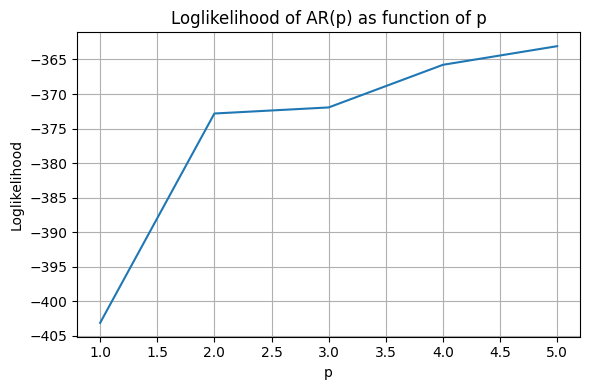

In [33]:
plt.figure(figsize=(6, 4))
plt.plot(range(1,6), logliks)
plt.title('Loglikelihood of AR(p) as function of p')
plt.xlabel('p')
plt.ylabel('Loglikelihood')
plt.grid(True)
plt.tight_layout()
plt.show()

The likelihoood increases as we add parameters to the model, which is to be expected. The more parameters, the more flexible the model is, and the better it can fit data. The likelihood increases quite rapidly at first, and then more moderately, indicating that the more parameters might be overfitting the model. 

### 5.
**Increasing the capacity of the model is likely to increase its explanatory power, but it is important to explore the tradeoff between this and the increase in model parameters. Determine the optimal order p of the AR model by computing the log-likelihood-ratio test statistic. Start with Wilk’s D, which simplifies here to**
$$D = −2[\log \Sigma_p − \log \Sigma_{p−1}]$$
**Plug $D$ into a $\chi^2$ distribution with appropriate degrees of freedom (scipy.stats.chi2.cdf() in Python). Start with the comparison between an AR(2) vs. $AR(1)$ model, and then keep on computing log-likelihood-ratio test statistics for models of consecutive orders up to order $p = 5$, estimating what the best order model is.**

We calculate the p-value of Wilks test statistic for the models AR(2) vs. AR(1) by calculating 2 times the log of the likelihood ratio and plugging into the distribution function of the chi squared distribution, yielding the following p-value

In [34]:
1 - scipy.stats.chi2.cdf(2*(logliks[1]-logliks[0]),1)

np.float64(6.8833827526759706e-15)

Which is highly significant. We repeat the procedure for the models of consecutive order up to $p=5$:

In [35]:
print(1 - scipy.stats.chi2.cdf(2*(logliks[2]-logliks[1]),1))
print(1 - scipy.stats.chi2.cdf(2*(logliks[3]-logliks[2]),1))
print(1 - scipy.stats.chi2.cdf(2*(logliks[4]-logliks[3]),1))

0.18481545423532209
0.0004423503668417039
0.02012324594231929


The p-value for the log likelihood ratio test statistic for the models AR(3) vs. AR(2) is insignificant, indicating that little is to be gained by increasing p from 2 to 3. The optimal model is thus AR(2), which is supported by the plot from the previous task. 

## Task 2. Multivariate (vector) AR (=VAR) processes

In [36]:
dlpfc1 = data['DLPFC1']
dlpfc2 = data["DLPFC2"]
parietal1 = data['Parietal1']
parietal2 = data['Parietal2']


dlpfc1 = dlpfc1.flatten()
dlpfc2 = dlpfc2.flatten()
parietal1 = parietal1.flatten()
parietal2 = parietal2.flatten()

In [37]:
# stack into one timeseries
X = np.vstack([dlpfc1, dlpfc2, parietal1, parietal2]).T

# Create lagged matrix Y_{t-1}
X_t = X[1:]
X_tm1 = X[:-1]

A = np.linalg.lstsq(X_tm1, X_t, rcond=None)[0].T 
print(f"A:{A}")

eigvals = np.linalg.eigvals(A)
is_stationary = np.all(np.abs(eigvals) < 1)

print(f"stationary: {is_stationary} eigenvals: {eigvals}")


A:[[ 0.90667017 -0.02038335  0.01566929 -0.03367666]
 [ 0.00979767  0.89861712 -0.0051275  -0.007468  ]
 [-0.0122504   0.04522748  0.87264112  0.00167771]
 [ 0.15376596 -0.09838665  0.01417625  0.93740375]]
stationary: True eigenvals: [0.91438159+0.06383083j 0.91438159-0.06383083j 0.89328448+0.01113259j
 0.89328448-0.01113259j]


A[i, j] represents the influence of variable j at time t-1 on variable i at time t.



## Task 3. AR Poisson processes

### 1. 
**Recall the equations for a Poisson process. Write them down and explain the reason behind the use of the link function, the logarithm.**

Let $c_t = (c_{1t}, ..., c_{kt})$ be observed counts for $t= 1,...,T$. Where $c_{it} \in \mathbb{N}$ for $i=1,...,k$. Assuming $c_{it}|c_{t-1},...,c_{t-p} \sim \operatorname{Pois}(\lambda_{it})$, we can model the mean $\lambda_{t}$ by
$$\log \lambda_t = a_0 + \sum_{j=1}^p A_j c_{t-j}$$

We use the log link, as we in this way make sure the mean is mapped to a positive value, as
$$ \lambda_t = \exp(a_0 + \sum_{j=1}^p A_j c_{t-j})$$
The Poisson process can only have a positive mean therefore this is a resonable choice. 

### 2. 
**Create your own second order Poisson time series with T = 1000 time steps and the following given parameters:**

In [38]:
T = 1000
A1 = np.array([[0.2,-0.1], [0.1, 0.1]])
A2 = np.array([[0.1, -0.1], [0.1, 0.1]])
mu0 = [0.5,0.5]
a0 = [0,0]

We interpret the question such that $c_{-1}, c_{0} \sim Pois(\exp \mu_0)$ and that
$$c_t \sim Pois(\exp \lambda_t), \quad t = 1, ..., T$$
Where
$$\log \lambda_t = a_0 + A1 c_{t-1} + A2 c_{t-2}$$ 
This is implemented below

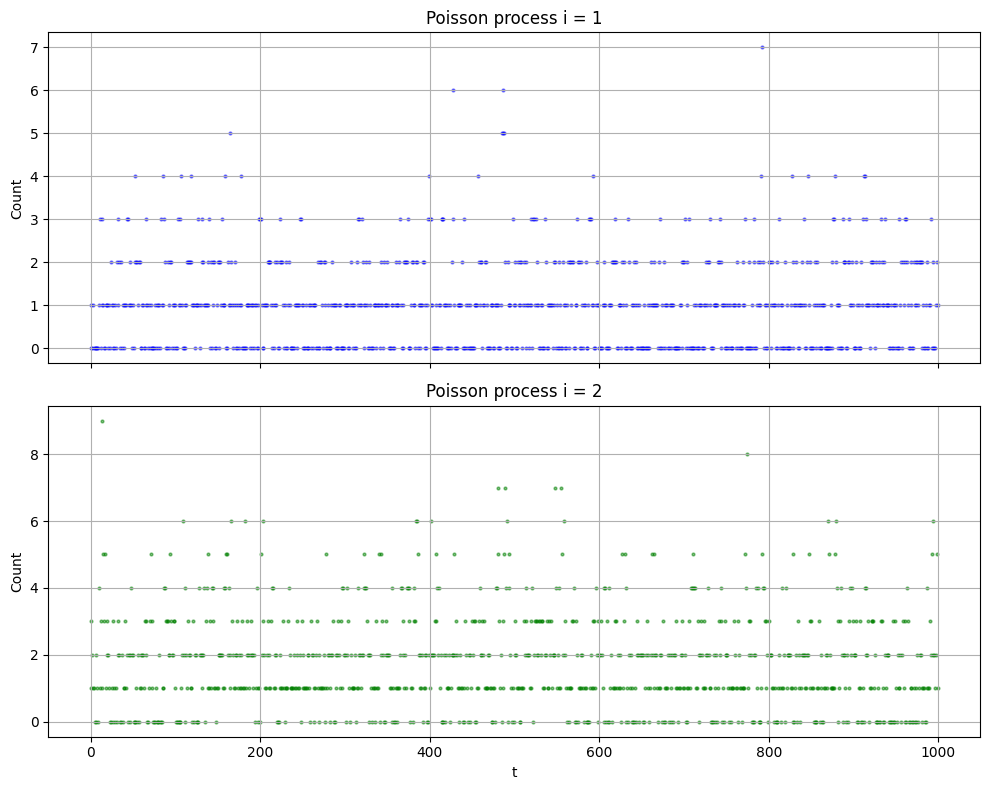

In [39]:
np.random.seed(99877)

# Initialize with zeros for c_{-1}, c_{0}
cs = np.zeros(((T+2), 2), dtype=int)
lambda_t = np.zeros(((T+2), 2), dtype=float)
cs[0] = np.random.poisson(np.exp(mu0))
cs[1] = np.random.poisson(np.exp(mu0))

# Generate the series
for t in range(2, T+2):
    lambda_t[t] = np.exp(a0 + A1 @ cs[t - 1] + A2 @ cs[t - 2])
    cs[t] = np.random.poisson(lambda_t[t])
    
    
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)

# First plot (i = 1)
axes[0].scatter(range(0, 1000), cs[2:, 0], s=4, color="blue", alpha=0.5)
axes[0].set_title('Poisson process i = 1')
axes[0].set_ylabel('Count')
axes[0].grid(True)

# Second plot (i = 2)
axes[1].scatter(range(0, 1000), cs[2:, 1], s=4, color="green", alpha=0.5)
axes[1].set_title('Poisson process i = 2')
axes[1].set_xlabel('t')
axes[1].set_ylabel('Count')
axes[1].grid(True)

plt.tight_layout()
plt.show()

### 3.
**Now we want to think about the log-likelihood landscape (log likelihood dependent on more than one parameter). What form do you expect theoretically? Why can it be important to know the form of this landscape?**

It is hard to imagine the shape of the landscape as there are many parameters in the model. As far as I can see, none of them have restrictions. The parameter values are in most cases probably not centered too far from 0. It was mentioned in the lecture that the optimization problem is convex, so this would mean that the landscape would be nice and have an optimum in the optimal parameters. In general the form of the log likelihood landscape is important for optimization tasks. If there are areas of the landscape that are non convex, then the optimizer can get stuck in these areas. 

It is important to know the landscape, to estiamte the postiontion of the optimum, the confidence we make that decision (by looking at the curvature and width of the optimum) and also the smoothness of the landscape (stability of our solution).


### 4. 
**Given the data generated in (a), vary the parameters A1(1, 1) and A2(2, 1) between 0 and 0.4 with 0.01 increments. For each parameter value pair, compute the log-likelihood of the data (keeping all other parameters fixed!). Plot the log-likelihood landscape surface as a function of these two parameters. Does the real parameter pair value correspond (or is close) to an extreme point in the approximate log-likelihood landscape? What kind of an extreme point is it?**

The log likelihood of data assuming the Poisson model described above is given by
$$\mathcal{l}_{\{c_t\}}(A_j, a_0) = \sum_{t=0}^T\sum_{i=1}^T (c_{it} \log \lambda_{it} - \lambda_{it} - K)$$
Where $K$ is some constant. 

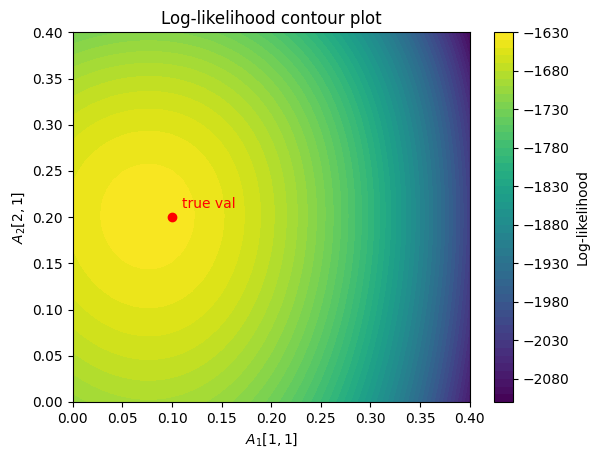

In [44]:
changing_vals = np.arange(0,0.41, 0.01) 

logliks = np.zeros((len(changing_vals), len(changing_vals)))

for k in range(len(changing_vals)):
    A1[0,0] = changing_vals[k]
    for j in range(len(changing_vals)):
        A2[1,0] = changing_vals[j]

        # calculating lambdas
        lambda_t = np.zeros(((T+2), 2))
        for t in range(2, T + 2):
            lambda_t[t] = np.exp(a0 + A1 @ cs[t - 1] + A2 @ cs[t - 2])

        # calculating log likelihood
        i1 = sum(cs[2:, 0] * np.log(lambda_t[2:,0]) - lambda_t[2:,0])
        i2 = sum(cs[2:, 1] * np.log(lambda_t[2:,1]) - lambda_t[2:,1])

        logliks[k,j] = i1 + i2
        
a1_11, a2_21 = np.meshgrid(changing_vals, changing_vals)

plt.contourf(a1_11, a2_21, logliks, levels=50, cmap='viridis')
plt.colorbar(label='Log-likelihood')
plt.xlabel(r'$A_{1}[1,1]$')
plt.ylabel(r'$A_{2}[2,1]$')
plt.title('Log-likelihood contour plot')
plt.plot(0.1, 0.2, 'ro', label='true val')
plt.text(0.1 + 0.01, 0.2 + 0.01, 'true val', color='red')
plt.show()

So the MLE estimates (the optimum of the loglikelihood function) is quite close to the true parameter estimates. They are not exactly the same because of the randomness in data. 